#### Template notebook, duplicate this file and rename according to the measurement period

# Load modules

In [212]:
import sys
import importlib
import itertools
from pathlib import Path
import os

root = Path(r'./').parent.absolute() # path to simpleNFB parent folder
parent = os.path.dirname(root) # path to simpleNFB parent folder

sys.path.append(f'{parent}\\simpleNFB\\spmpy') # folder containing spmpy import
sys.path.append(f'{parent}\\simpleNFB') # folder containing the snfb import
#sys.path.append(r'C:\Users\Lab205.EMPA\Documents\GitHub\simpleNFB\simpleNFB')
#sys.path.append(r'C:\Users\amsp\Documents\Python\simpleNFB\simpleNFB') # absolute path to the snfb folder, use if you move this notebook to a new directory

#[print(p) for p in sys.path];
import snfb
import spmpy # <-- Spm class


importlib.reload(snfb)

import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython import display
from IPython.display import HTML
display.display(HTML("<style>.container { width:100% !important; }</style>"))


'''
copy and paste the tip time or session folder directory into the session text box at the top of each browser
the session directory is used as a reference location for the collection of measurement folders containing .dat and .sxm files
The browsers are capable of seeing files within sub-directories of the active_Directory, e.g., 

/active_Directory
    /00_Au111_clean
        /img0001.sxm
        /img0002.sxm
        /dIdV0001.dat
        /dIdV0002.dat
    /01_Au111_NaCl
        /img0001.sxm
        /img0002.sxm
        /dIdV0001.dat
        /dIdV0002.dat
        
the folders 00_Au111_clean and 01_Au111_NaCl will be selectable in the browser Folders selection list
the sxm and dat files will be visible in the Files selction list of the imageBrowser and specBrowser, respectively
'''

%matplotlib widget

# Browser .SXM Files

In [191]:
# closes previous imageBrowser figure if it exists
figs = list(plt.get_figlabels())
if 'sxm' in figs: plt.close('sxm')
imageBrowser = snfb.sxmBrowser(figsize=(10,6),titlesize=9,fontsize=20,cmap='gist_gray')
imageBrowser.rootFolder.value = r'K:\Labs205\Labs\THz-STM\raw data\amsp\porphyrin\735a_CarboxyDiPhenaPorph_H3_01'
### the browser has many toggle buttons whose state is read during image plotting
### these button can be updated directly (shown below) to create a consistent experience each time the cell is run
imageBrowser.configOptionBtn.value = True
imageBrowser.labelToggle.value = True
imageBrowser.channelToggle.value = False
imageBrowser.setpointToggle.value = False
imageBrowser.feedbackToggle.value = False
imageBrowser.depthSelection.value = 3
imageBrowser.nameToggle.value = False
imageBrowser.directionToggle.value = False
imageBrowser.dateToggle.value = False

Box(children=(Box(children=(Label(value='Session', layout=Layout(display='flex', justify_content='flex-start',…

# Browse .Dat Files

In [215]:
# closes previous specBrowser figure if it exists
figs = list(plt.get_figlabels())
if 'dat' in figs: plt.close('dat')
specBrowser = snfb.datBrowser(figsize=(6,4),titlesize=5,sxmBrowser=imageBrowser,cmap='tab10')
specBrowser.rootFolder.value = r'K:\Labs205\Labs\THz-STM\raw data\amsp\porphyrin\735a_CarboxyDiPhenaPorph_H3_01'
### the browser has many toggle buttons whose state is read during image plotting
### these button can be updated directly (shown below) to create a consistent experience each time the cell is run
specBrowser.settingsBtn.value = True
specBrowser.depthSelection.value = 3
specBrowser.nameToggle.value = False

Box(children=(Box(children=(Label(value='Session', layout=Layout(display='flex', justify_content='flex-start',…

In [9]:
### Annotate Wavelength and Intensity Peaks & ### Annotate maximal dI/dV value in all selected STS spectra

import ipywidgets as ipy

# region: Annotate Wavelength and Intensity Peaks

def annotate_peak(specBrowser, x_target, vline=False):
    y = specBrowser.spec[0].napImport.signals["Intensity"]
    x = specBrowser.spec_x
    idx = (np.abs(np.array(x) - x_target)).argmin()
    y_target = y[idx]
    
    # Plot marker and annotation
    specBrowser.axes.plot(x_target, y_target, marker='^', color='black', markersize=6)
    specBrowser.axes.annotate(f'{y_target:.2f} cts',
                              xy=(x_target, y_target),
                              xytext=(x_target + 10, y_target*1.1),
                              ha='center', fontsize=8, color='black')
    
    # Optional vertical line
    if vline:
        specBrowser.axes.vlines(x_target, 0, y_target, color='black', alpha=0.5, lw=0.4)

# # Call for each target x value
# for x_target in [515, 632]:
#     annotate_peak(specBrowser, x_target, vline=(x_target))

# endregion

# region: Annotate maximal dI/dV value in all selected STS spectra

def annotate_max_dIdV(specBrowser):

    specs_max_points = []

    for y_spec in specBrowser.spec:
        y_spec_data = y_spec.napImport.signals["LI Demod 1 X (A)"]
        x_spec_data = y_spec.napImport.signals["Bias (V)"]
        y_max_idx = np.argmax(y_spec_data)
        x_max = x_spec_data[y_max_idx]
        y_max = y_spec_data[y_max_idx]
        specs_max_points.append((x_max, y_max))

        # Plotting marker and annotations
        specBrowser.axes.plot(x_max, y_max*1e12, marker='^', markersize=6, color='black')
        specBrowser.axes.annotate(f'({y_max*1e12:.1f})', 
                                xy=(x_max, y_max*1e12), 
                                xytext=(5, 0), 
                                textcoords='offset points', 
                                fontsize=8, 
                                color='black')

# annotate_max_dIdV(specBrowser)

# endregion

# region: Change y_lim and x_lim in specBrowser

def change_ylim(specBrowser, new_ylim:tuple[float, float]):
    specBrowser.axes.set_ylim(new_ylim)

def change_xlim(specBrowser, new_xlim:tuple[float, float]):
    specBrowser.axes.set_xlim(new_xlim)


# Widget Implementation

def annotate_peaks_call_function(change):
    if 'specBrowser' in globals():
        for x_target in [515, 632]:
            annotate_peak(specBrowser, x_target, vline=(x_target))
    else:
        print("Please load spectra in the specBrowser first.")

annotate_peaks_button = ipy.Button(description="Annotate STML Peaks (515nm, 632nm)", layout=ipy.Layout(width='250px',height='30px'))
annotate_peaks_button.on_click(annotate_peaks_call_function)

def annotate_max_dIdV_call_function(change):
    if 'specBrowser' in globals():
        annotate_max_dIdV(specBrowser)
    else:
        print("Please load spectra in the specBrowser first.")

annotate_max_dIdV_button = ipy.Button(description="Annotate max dI/dV", layout=ipy.Layout(width='150px',height='30px'))
annotate_max_dIdV_button.on_click(annotate_max_dIdV_call_function)

def update_ylim_call_function(change):
    if 'specBrowser' in globals():
        new_ylim = (ylim_input1.value, ylim_input2.value)
        change_ylim(specBrowser, new_ylim)
    else:
        print("Please load spectra in the specBrowser first.")

def update_xlim_call_function(change):
    if 'specBrowser' in globals():
        new_xlim = (xlim_input1.value, xlim_input2.value)
        change_xlim(specBrowser, new_xlim)
    else:
        print("Please load spectra in the specBrowser first.")

ylim_input1 = ipy.IntText(value=0, description='Y Lim Min:',layout=ipy.Layout(width='150px',height='30px'))
ylim_input2 = ipy.IntText(value=100, description='Y Lim Max:',layout=ipy.Layout(width='150px',height='30px'))
ylim_update_button = ipy.Button(description="Update Y Lim", layout=ipy.Layout(width='100px',height='30px'))
ylim_update_button.on_click(update_ylim_call_function)
ylim_widgets = ipy.HBox([ylim_input1, ylim_input2, ylim_update_button])
xlim_input1 = ipy.IntText(value=600, description='X Lim Min:',layout=ipy.Layout(width='150px',height='30px'))
xlim_input2 = ipy.IntText(value=700, description='X Lim Max:',layout=ipy.Layout(width='150px',height='30px'))
xlim_update_button = ipy.Button(description="Update X Lim", layout=ipy.Layout(width='100px',height='30px'))
xlim_update_button.on_click(update_xlim_call_function)
xlim_widgets = ipy.HBox([xlim_input1, xlim_input2, xlim_update_button])



### Change legend size
def change_legend_size(specBrowser, fontsize='xx-small'):
    specBrowser.axes.legend(fontsize=fontsize)

def change_legend_size_call_function(change):
    if 'specBrowser' in globals():
        change_legend_size(specBrowser)
    else:
        print("Please load spectra in the specBrowser first.")

change_legend_size_button = ipy.Button(description="Change Legend Size", layout=ipy.Layout(width='150px',height='30px'))
change_legend_size_button.on_click(change_legend_size_call_function)

widgets_to_display = ipy.VBox([ipy.HBox([annotate_peaks_button, annotate_max_dIdV_button]),
                                ylim_widgets,
                                xlim_widgets,
                                change_legend_size_button])
display.display(widgets_to_display)

### How to access data from the browsers

call help(imageBrowser) or help(specBrowser) for additional details

-- Both Browsers --

when a file or files are selected the files are opened through the spmpy library as an Spm file

the Spm file has a two important functions: get_channel('data_channel') and get_param('measurement_parameter')

the Spm files also have access to the nanonis file headers as spm_file.header = {'keys':values}; eg, spm_file.header["experiment"] == bias_spectroscopy

-- SXM Browser --

image_data = imageBrowser.image_data --> this is the raw image_data and does not include any post-processing that is applied in the browser figure

-- DAT Browser --

The dat browser is capable of displaying multiple files, therefore the data arrays from each file are stored in a pair of lists:

y_channel_data = specBrowser.spec

x_channel_data = specBrowser.spec_x


# Analysis example: Waterfall Plot - dI/dV vs Distance

dataMin: -1800.9037955776255, dataMax: 224.45760503995675


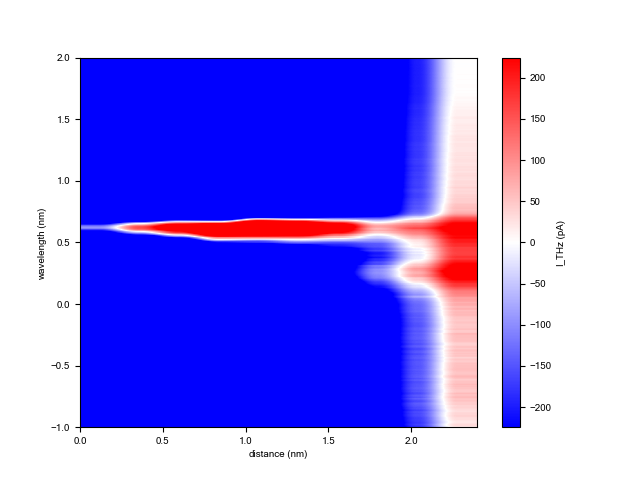

In [7]:
from matplotlib.colors import LogNorm
positions = []
distances = []
for spec in specBrowser.spec:
    positions.append([spec.get_param('x')[0],spec.get_param('y')[0]])
x_0,y_0 = positions[0]
for p in positions:
    x_a = p[0]-x_0
    y_a = p[1]-y_0
    distances.append(np.sqrt(x_a**2 + y_a**2))
fig = plt.figure()
try :
    fig = plt.close(fig)
except:
    pass
fig = plt.figure()
dataMin = np.min(specBrowser.spec_data)
dataMax = np.max(specBrowser.spec_data)/3
print(f'dataMin: {dataMin}, dataMax: {dataMax}')
im = plt.imshow(np.flip(np.rot90(specBrowser.spec_data)),extent=[distances[0],distances[-1],-1.0,2.0],aspect='auto',cmap='bwr',vmin=-dataMax, vmax= dataMax) #,norm=LogNorm(vmin=2e-2,vmax=dataMax)
#plt.imshow(np.rot90(specBrowser.spec_data),extent=[1,len(specBrowser.spec_data),-1.5,1.5],aspect='auto',cmap='jet') #,norm=LogNorm(vmin=2e-14,vmax=dataMax)
#plt.ylim([-3.8, 2])
#plt.ylim([700, 750])
plt.xlabel('distance (nm)')
plt.ylabel('wavelength (nm)')
plt.colorbar(im, label='I_THz (pA)')

#plt.title(')

In [ ]:
from matplotlib.colors import LogNorm
positions = []
distances = []
for spec in specBrowser.spec:
    positions.append([spec.get_param('x')[0],spec.get_param('y')[0]])
x_0,y_0 = positions[0]
for p in positions:
    x_a = p[0]-x_0
    y_a = p[1]-y_0
    distances.append(np.sqrt(x_a**2 + y_a**2))
fig = plt.figure()
try :
    fig = plt.close(fig)
except:
    pass
fig = plt.figure()
dataMin = np.min(specBrowser.spec_data)
dataMax = np.max(specBrowser.spec_data)
print(f'dataMin: {dataMin}, dataMax: {dataMax}')
im = plt.imshow(np.rot90(specBrowser.spec_data),extent=[distances[0],distances[-1],620,678],aspect='auto',cmap='bwr',vmin=0, vmax= 1000) #,norm=LogNorm(vmin=2e-2,vmax=dataMax)
#plt.imshow(np.rot90(specBrowser.spec_data),extent=[1,len(specBrowser.spec_data),-1.5,1.5],aspect='auto',cmap='jet') #,norm=LogNorm(vmin=2e-14,vmax=dataMax)
#plt.ylim([-3.8, 2])
#plt.ylim([700, 750])
plt.xlabel('distance (nm)')
plt.ylabel('wavelength (nm)')
plt.colorbar(im, label='counts (pA)')

#plt.title(')

In [ ]:
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
positions = []
distances = []
for spec in specBrowser.spec:
    positions.append([spec.get_param('x')[0],spec.get_param('y')[0]])
x_0,y_0 = positions[0]
for p in positions:
    x_a = p[0]-x_0
    y_a = p[1]-y_0
    distances.append(np.sqrt(x_a**2 + y_a**2))
fig = plt.figure()
try :
    fig = plt.close(fig)
except:
    pass
fig = plt.figure()
dataMin = np.min(specBrowser.spec_data)
dataMax = 0.8#np.max(specBrowser.spec_data)
print(f'dataMin: {dataMin}, dataMax: {dataMax}')
im = plt.imshow(np.rot90((specBrowser.spec_data)),extent=[distances[0],distances[-1],-1.0,1.3],aspect='auto',cmap='bwr',vmin=-dataMax, vmax= dataMax) #,norm=LogNorm(vmin=2e-2,vmax=dataMax)
#im = plt.imshow(np.rot90(np.fliplr(specBrowser.spec_data)),extent=[distances[0],distances[-1],-0.4,1.2],aspect='auto',cmap='bwr',norm=colors.SymLogNorm(linthresh=0.05,vmin=-3, vmax=3, base=10) )
#plt.imshow(np.rot90(specBrowser.spec_data),extent=[1,len(specBrowser.spec_data),-1.5,1.5],aspect='auto',cmap='jet') #,norm=LogNorm(vmin=2e-14,vmax=dataMax)
#plt.ylim([-3.8, 2])
#plt.ylim([700, 750])
plt.xlabel('distance (nm)')
plt.ylabel('bias (V)')
plt.colorbar(im, label='I_THz (pA)')

# Bias spec vs. delay

In [ ]:
from matplotlib.colors import LogNorm
positions = []
delays =  np.arange(300,300+25*len(specBrowser.spec_data),25) #[ps]

fig = plt.figure()
dataMin = np.min(specBrowser.spec_data)
dataMax = np.max(np.absolute(specBrowser.spec_data))
print(f'dataMin: {dataMin}, dataMax: {dataMax}')
im = plt.imshow(np.rot90((specBrowser.spec_data)),extent=[delays[0],delays[-1],-1.6,1.2],aspect='auto',cmap='bwr',vmin=-dataMax, vmax= dataMax) #,norm=LogNorm(vmin=2e-2,vmax=dataMax)
#plt.imshow(np.rot90(specBrowser.spec_data),extent=[1,len(specBrowser.spec_data),-1.5,1.5],aspect='auto',cmap='jet') #,norm=LogNorm(vmin=2e-14,vmax=dataMax)
#plt.ylim([-3.8, 2])
#plt.ylim([700, 750])
plt.xlabel('delay THz1 (ps)')
plt.ylabel('bias (V)')
plt.colorbar(im, label='I_THz (pA)')

In [ ]:
from matplotlib.colors import LogNorm
positions = []
delays =  np.arange(900,900+20*len(specBrowser.spec_data),20) #[ps]

delta_data = []
ref = np.mean(specBrowser.spec_data[0:2],axis=0)
for spec in specBrowser.spec_data:
    delta_data.append(spec-ref)


fig = plt.figure()
dataMax = np.max(np.absolute(delta_data))
print(f'dataMin: {dataMin}, dataMax: {dataMax}')
#im = plt.imshow(np.rot90(np.fliplr(delta_data)),extent=[delays[0],delays[-1],-0.4,1.2],aspect='auto',cmap='bwr',vmin=-dataMax, vmax= dataMax) #,norm=LogNorm(vmin=2e-2,vmax=dataMax)
im = plt.imshow(np.rot90(np.fliplr(specBrowser.spec_data)),extent=[delays[0],delays[-1],-0.4,1.2],aspect='auto',cmap='bwr',norm=colors.SymLogNorm(linthresh=0.5,vmin=-3, vmax=3, base=10) )
#plt.ylim([-3.8, 2])
#plt.ylim([700, 750])
plt.xlabel('delay Vis-THz1 (ps)')
plt.ylabel('bias (V)')
plt.colorbar(im, label='ΔI_THz (pA)')

In [ ]:
from matplotlib.colors import LogNorm
positions = []
distances = []
for spec in specBrowser.spec:
    positions.append([spec.get_param('x')[0],spec.get_param('y')[0]])
x_0,y_0 = positions[0]
for p in positions:
    x_a = p[0]-x_0
    y_a = p[1]-y_0
    distances.append(np.sqrt(x_a**2 + y_a**2))
fig = plt.figure()
try :
    fig = plt.close(fig)
except:
    pass
fig = plt.figure()
dataMin = np.min(specBrowser.spec_data)
dataMax = np.max(specBrowser.spec_data)
plt.imshow(np.rot90(specBrowser.spec_data),extent=[distances[0],distances[-1],-3.8,2],aspect='auto',cmap='jet',norm=LogNorm(vmin=2e-14,vmax=dataMax)) #,norm=LogNorm(vmin=2e-14,vmax=dataMax)
#plt.imshow(np.rot90(specBrowser.spec_data),extent=[1,len(specBrowser.spec_data),-1.5,1.5],aspect='auto',cmap='jet') #,norm=LogNorm(vmin=2e-14,vmax=dataMax)
plt.xlabel('distance (nm)')
plt.ylabel('Bias (V)')
plt.colorbar()
plt.title('dI/dV')

# bias spec vs. z

In [ ]:
from matplotlib.colors import LogNorm
zs = []
positions = []
for spec in specBrowser.spec:
    positions.append(spec.get_param('z')[0])
z_0 = positions[0]+0.45
for z in positions:
    zs.append(z-z_0)
fig = plt.figure()
try :
    fig = plt.close(fig)
except:
    pass
fig = plt.figure()
dataMin = np.min(specBrowser.spec_data)
dataMax = np.nanmax(np.absolute(specBrowser.spec_data))*1
print(f'dataMin: {dataMin}, dataMax: {dataMax}')
print(f'z_0: {z_0}')
#im = plt.imshow(np.rot90((specBrowser.spec_data)),extent=[zs[0],zs[-1],-0.4,3.0],aspect='auto',cmap='bwr',vmin=-dataMax, vmax= dataMax) #,norm=LogNorm(vmin=2e-2,vmax=dataMax)
im = plt.imshow(np.rot90((specBrowser.spec_data)),extent=[zs[0],zs[-1],-0.8,3.0],aspect='auto',cmap='bwr',norm=colors.SymLogNorm(linthresh=0.5,vmin=-22, vmax=22, base=10) )
plt.xlabel('z (nm)')
plt.ylabel('Bias (V)')
plt.colorbar(im, label='I_THz (pA)')

### bias-spec vs. Power

In [ ]:
from matplotlib.colors import LogNorm
powers = [3.6,3.3,3.0,2.5,2.0,1.5,0]

try :
    fig = plt.close(fig)
except:
    pass
fig = plt.figure()
dataMin = np.min(specBrowser.spec_data)
dataMax = np.nanmax(np.absolute(specBrowser.spec_data))*1
print(f'dataMin: {dataMin}, dataMax: {dataMax}')
print(f'z_0: {z_0}')
#im = plt.imshow(np.rot90((specBrowser.spec_data)),extent=[zs[0],zs[-1],-0.4,3.0],aspect='auto',cmap='bwr',vmin=-dataMax, vmax= dataMax) #,norm=LogNorm(vmin=2e-2,vmax=dataMax)
im = plt.imshow(np.rot90((specBrowser.spec_data)),extent=[powers[0],powers[-1],-0.4,1.2],aspect='auto',cmap='bwr',norm=colors.SymLogNorm(linthresh=0.5,vmin=-22, vmax=22, base=10) )
plt.xlabel('vis power (mW)')
plt.ylabel('Bias (V)')
plt.colorbar(im, label='I_THz (pA)')

In [ ]:
### bias-spec vs. lambda half angle

In [ ]:

from matplotlib.colors import LogNorm
angles = np.arange(0, 90, 5) # half angles in degrees

try :
    fig = plt.close(fig)
except:
    pass
fig = plt.figure()
dataMin = np.min(specBrowser.spec_data)
dataMax = np.nanmax(np.absolute(specBrowser.spec_data))*1
print(f'dataMin: {dataMin}, dataMax: {dataMax}')
print(f'z_0: {z_0}')
#im = plt.imshow(np.rot90((specBrowser.spec_data)),extent=[zs[0],zs[-1],-0.4,3.0],aspect='auto',cmap='bwr',vmin=-dataMax, vmax= dataMax) #,norm=LogNorm(vmin=2e-2,vmax=dataMax)
im = plt.imshow(np.rot90((specBrowser.spec_data)),extent=[angles[0],angles[-1],-0.4,1.2],aspect='auto',cmap='bwr',norm=colors.SymLogNorm(linthresh=0.5,vmin=-22, vmax=22, base=10) )
plt.xlabel('vis power (mW)')
plt.ylabel('Bias (V)')
plt.colorbar(im, label='I_THz (pA)')from matplotlib.colors import LogNorm


### bias-spec vs. pointing

In [ ]:
steps = np.arange(0,500,50) # half angles in degrees

try :
    fig = plt.close(fig)
except:
    pass
fig = plt.figure()
dataMin = np.min(specBrowser.spec_data)
dataMax = np.nanmax(np.absolute(specBrowser.spec_data))*1
print(f'dataMin: {dataMin}, dataMax: {dataMax}')
print(f'z_0: {z_0}')
#im = plt.imshow(np.rot90((specBrowser.spec_data)),extent=[zs[0],zs[-1],-0.4,3.0],aspect='auto',cmap='bwr',vmin=-dataMax, vmax= dataMax) #,norm=LogNorm(vmin=2e-2,vmax=dataMax)
im = plt.imshow(np.rot90(np.fliplr(specBrowser.spec_data)),extent=[steps[0],steps[-1],-0.4,1.2],aspect='auto',cmap='bwr',norm=colors.SymLogNorm(linthresh=0.5,vmin=-22, vmax=22, base=10) )
plt.xlabel('vis pointing (steps of motor2)')
plt.ylabel('Bias (V)')
plt.colorbar(im, label='I_THz (pA)')

# Preview all matplotlib colormaps

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_all_cmaps():
    N_ROWS, N_COLS = 8, 7 # 13, 13 <-- for all in one figure 
    HEIGHT, WIDTH = 7, 14

    cmap_ids = plt.colormaps()
    n_cmaps = len(cmap_ids)
    
    print(f'mpl version: {mpl.__version__},\nnumber of cmaps: {n_cmaps}')
    
    index = 0
    while index < n_cmaps:
        fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(WIDTH, HEIGHT))
        for row in range(N_ROWS):
            for col in range(N_COLS):
                ax = axes[row, col]
                cmap_id = cmap_ids[index]
                cmap = plt.get_cmap(cmap_id)
                mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                          orientation='horizontal')
                ax.set_title(f"'{cmap_id}', {index}", fontsize=8)
                ax.tick_params(left=False, right=False, labelleft=False,
                               labelbottom=False, bottom=False)
                
                last_iteration = index == n_cmaps-1
                if (row==N_ROWS-1 and col==N_COLS-1) or last_iteration:
                    plt.tight_layout()
                    #plt.savefig('colormaps'+str(index)+'.png')
                    plt.show()
                    if last_iteration: return
                index += 1

plot_all_cmaps()